## Travelling Salesman Problem

Problem Statement: The delivery person is currently at location 1 and needs to deliver the package to customers at all the other locations and then return back to location 1. Assuming the time for consumers to pick up their delivery is zero, the objective of the delivery problem is to minimize the total traveling time (or waiting time of the consumers).

#### Locations the salesman need to visit 

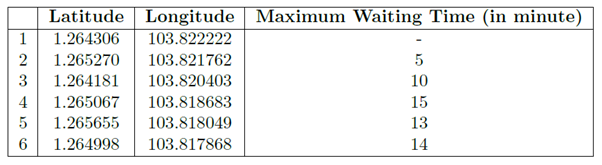

#### Pairwise Walking Time between locations
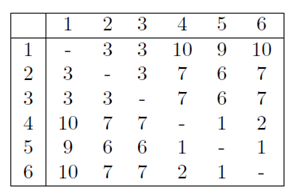

#### Model by Miller, Tucker and Zemlin

\begin{equation}
\begin{split}
\min~ & \sum_{i=1}^n\sum_{j=1}^nc_{ij}x_{ij} \\
s.t. ~& \sum_{i=1}^nx_{ij} =1, ~ j =1,...,n\\
& \sum_{j=1}^nx_{ij} =1, ~ i =1,...,n\\
& u_i + 1 - u_j \leq M(1 - x_{ij}), ~ i\neq j, 1\leq i\leq n, 2\leq j \leq n \\ 
& x_{ij}\in\{0,1\}, u_i\geq 0, i =1,...,n.
\end{split}
\end{equation}

#### Minimum traveling time and route to traverse the locations of all customers and returning to location 1 (not considering maximum waiting time of the consumer)

In [10]:
from gurobipy import *
import numpy as np

# Parameters Set-up

# Pairwise Walking Time from node i to node j

cost = np.array([[1000, 3, 3, 10, 9, 10],
                 [3, 1000, 3, 7, 6, 7],
                 [3, 3, 1000, 7, 6, 7],
                 [10, 7, 7, 1000, 1, 2],
                 [9, 6, 6, 1, 1000, 1],
                 [10, 7, 7, 2, 1, 1000]])
N = cost.shape[0]

#the big M
M = 10000

In [11]:
# Model Set-up

tsp = Model("traveling_salesman")


# Creat variables
x = tsp.addVars(N, N, vtype=GRB.BINARY, name = "x")

u = tsp.addVars(N, name = "u")

# Set objective
tsp.setObjective( quicksum(cost[i,j]*x[i,j] for i in range(N) for j in range(N)), GRB.MINIMIZE)

# Assignment constraints:
tsp.addConstrs(( quicksum(x[i,j] for j in range(N)) == 1 for i in range(N) ))
 
tsp.addConstrs(( quicksum(x[i,j] for i in range(N)) == 1 for j in range(N) ))

# Subtour-breaking constraints:
tsp.addConstrs(( u[i] + 1 - u[j] <= M*(1 - x[i,j])  for i in range(N) for j in range(1,N) ))

# Solving the model
tsp.optimize()


Optimize a model with 42 rows, 42 columns and 152 nonzeros
Variable types: 6 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 37.0000000
Presolve removed 5 rows and 7 columns
Presolve time: 0.00s
Presolved: 37 rows, 35 columns, 150 nonzeros
Variable types: 5 continuous, 30 integer (30 binary)

Root relaxation: objective 1.300000e+01, 17 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   13.00000    0    6   37.00000   13.00000  64.9%     -    0s
H    0     0                      25.0000000   13.00000  48.0%     -    0s
     0     0   13.00000    0    6   25.00000   13.00000  48.0%     -    0s
H    0     0                      22.0000000   13.00000  40.9%     -    0s
  

In [12]:
#  Print optimal x for x nonzero and optimal value
s_edge = []
for v in x:    
    if x[v].x > 0.001:
        print(x[v].VarName, x[v].x)
        #add both of the indicies by 1
        edge = np.add(v, (1,1))
        #append the edge to the resulting list of edges
        s_edge.append(edge)


print('Obj:', tsp.objVal)
print(s_edge)
for v in u: 
    print(u[v].VarName, u[v].x)

x[0,2] 1.0
x[1,0] 1.0
x[2,3] 1.0
x[3,4] 1.0
x[4,5] 1.0
x[5,1] 1.0
Obj: 22.0
[array([1, 3]), array([2, 1]), array([3, 4]), array([4, 5]), array([5, 6]), array([6, 2])]
u[0] 0.0
u[1] 5.0
u[2] 1.0
u[3] 2.0
u[4] 3.0
u[5] 4.0


In [13]:
#  Obtain the permutation as a representation of the tour

permu = np.ones(N)
predecessor = 1
for i in range(N):
    for s in s_edge:
        if s[0] == predecessor:
            permu[i] = s[0]
            predecessor = s[1]
            break    
    
print(permu)

[1. 3. 4. 5. 6. 2.]


#### Conclusion

[ 1 > 3 > 4 > 5 > 6 > 2 > 1 ] is the optimal route as suggested by the model above (although not unique). The minimum walking time using the aforementioned route is 22 minutes 

#### Minimum traveling time and route (delivery before consumers maximum waiting time)

In [16]:
# Model Set-up

tsp = Model("traveling_salesman")

# Creat variables
x = tsp.addVars(N, N, vtype=GRB.BINARY, name = "x")
u = tsp.addVars(N, name = "u")

# waiting times
waiting_time = np.array([0, 5, 10, 15, 13, 14])

# Set objective
tsp.setObjective( quicksum(cost[i,j]*x[i,j] for i in range(N) for j in range(N)), GRB.MINIMIZE)

# Assignment constraints:
tsp.addConstrs(( quicksum(x[i,j] for j in range(N)) == 1 for i in range(N) ))
 
tsp.addConstrs(( quicksum(x[i,j] for i in range(N)) == 1 for j in range(N) ))

# Subtour-breaking constraints:
tsp.addConstrs(( u[i] + cost[i,j] - u[j] <= M*(1 - x[i,j])  for i in range(N) for j in range(1,N) ))

# Waiting time constraints
tsp.addConstrs( (u[i] <= waiting_time[i] for i in range(len(waiting_time))))

# Solving the model
tsp.optimize()


Optimize a model with 48 rows, 42 columns and 158 nonzeros
Variable types: 6 continuous, 36 integer (36 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 22 rows and 17 columns
Presolve time: 0.00s
Presolved: 26 rows, 25 columns, 134 nonzeros
Variable types: 4 continuous, 21 integer (21 binary)

Root relaxation: objective 1.300000e+01, 15 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   13.00000    0    6          -   13.00000      -     -    0s
H    0     0                      25.0000000   13.00000  48.0%     -    0s
     0     0   13.00000    0    6   25.00000   13.00000  48.0%     -    0s
     0     0   13.00000    0    6   25.00000   13.00000  48.0%     -    0s
     0     0   22.00000    0   11   25.00000   

In [17]:
#  Print optimal x for x nonzero and optimal value
s_edge = []
for v in x:    
    if x[v].x > 0.001:
        print(x[v].VarName, x[v].x)
        #add both of the indicies by 1
        edge = np.add(v, (1,1))
        #append the edge to the resulting list of edges
        s_edge.append(edge)


print('Obj:', tsp.objVal)
print(s_edge)
for v in u: 
    print(u[v].VarName, u[v].x)

x[0,1] 1.0
x[1,2] 1.0
x[2,4] 1.0
x[3,0] 1.0
x[4,5] 1.0
x[5,3] 1.0
Obj: 25.0
[array([1, 2]), array([2, 3]), array([3, 5]), array([4, 1]), array([5, 6]), array([6, 4])]
u[0] 0.0
u[1] 3.0
u[2] 6.0
u[3] 15.0
u[4] 11.99999999999994
u[5] 13.0


In [18]:
#  Obtain the permutation as a representation of the tour

permu = np.ones(N)
predecessor = 1
for i in range(N):
    for s in s_edge:
        if s[0] == predecessor:
            permu[i] = s[0]
            predecessor = s[1]
            break    
    
print(permu)

[1. 2. 3. 5. 6. 4.]


#### Conclusion

[ 1 > 2 > 3 > 5 > 6 > 4 > 1 ] is the optimal route as suggested by the model above. The minimum walking time using the aforementioned route is 25 minutes.